The source of our data is ["On the Use of Discriminant Functions in Taxonomy"](https://www.jstor.org/stable/2527894?seq=1#page_scan_tab_contents) by Alexander A. Lubischew. The dataset contains physical measures of on three species of flea beetles. The features are:

* species - One of concinna, heptapotamica or heikertingeri
* tars1 - width of the first joint of the first tarsus in microns
* tars2 - width of the second joint of the first tarsus in microns
* head - the maximal width of the head between the external edges of the eyes in 0.01 mm
* aede1 - the maximal width of the aedeagus in the fore-part in microns
* aede2 - the front angle of the aedeagus (1 unit = 7.5 degrees)
* aede3 - the aedeagus width from the side in microns

More explanations about the dataset can be found in the [Gobbi book](http://www.ggobi.org/book/).

This dataset is pretty small (74 rows), so we're not in the realm of Big Data. Can we still try to make meaningful predictions about the species? Let's find out!


# Warming up

We are going to use R and [JAGS](http://mcmc-jags.sourceforge.net/) to build a Bayesian model for our classification task. The model is heavily based on the excellent ["Doing Bayesian Data Analysis 2nd edition"](https://sites.google.com/site/doingbayesiandataanalysis/what-s-new-in-2nd-ed) by John K. Kruschke. If you can, get this book!

Let's import some packages into R and read our data. Please, install [JAGS](https://sourceforge.net/projects/mcmc-jags/files/) on your machine if you want to follow along.

In [88]:
library(rjags);
library(coda)
library(caret)
library(scales)
library(ggplot2)
library(runjags)
library(GGally)
library(reshape2)
library(plyr)
library(dplyr)

In [89]:
source("utils.R")

seed <- 42
set.seed(seed)
theme_set(theme_minimal())
options(warn=-1)

In [105]:
df <- read.csv("data/flea.csv", header = T)

# Exploration

Our dataset contains 74 rows with 7 variables each. We are going to answer one question: Given Flea Beetle measures what type of specie is it?

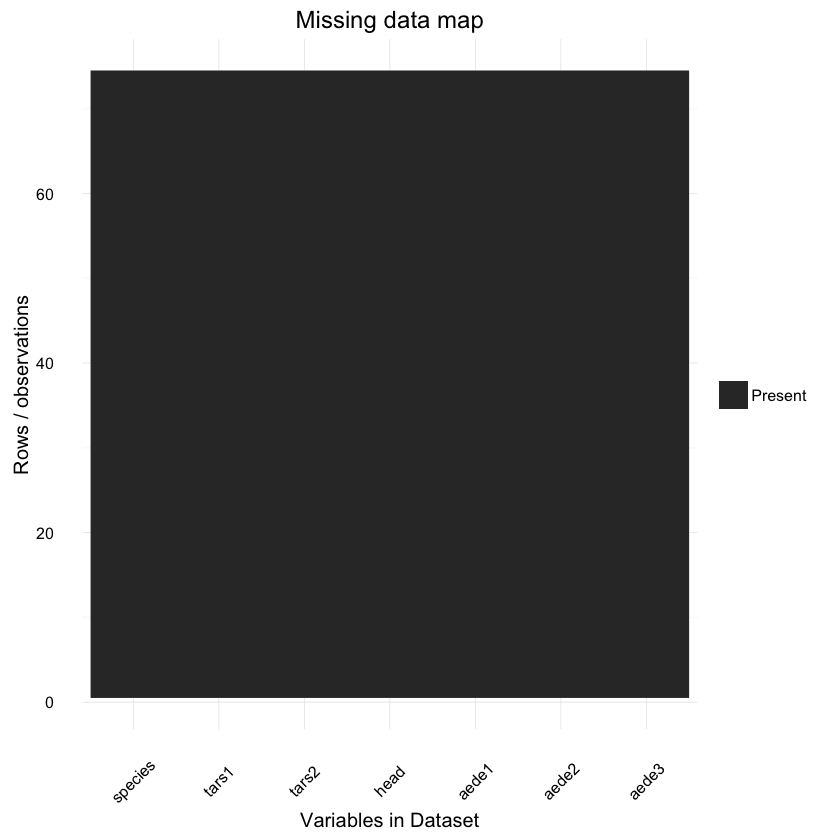

In [90]:
ggplot_missing(df)

How does the features in the dataset correlate to each other?

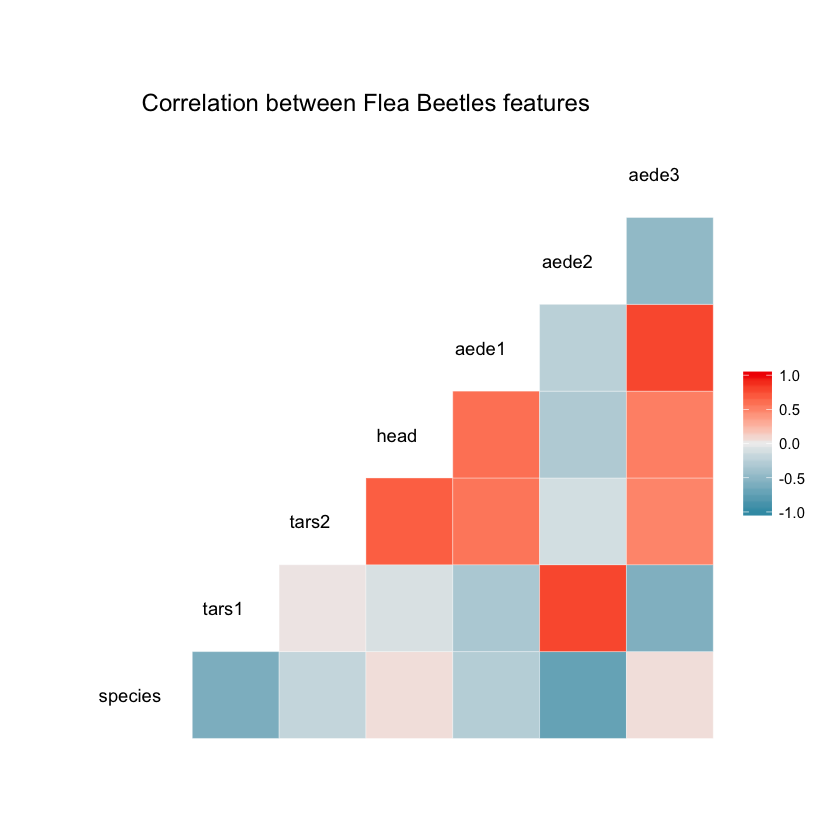

In [91]:
ggcorr(df, hjust = 0.8, layout.exp = 1) + 
    ggtitle("Correlation between Flea Beetles features")

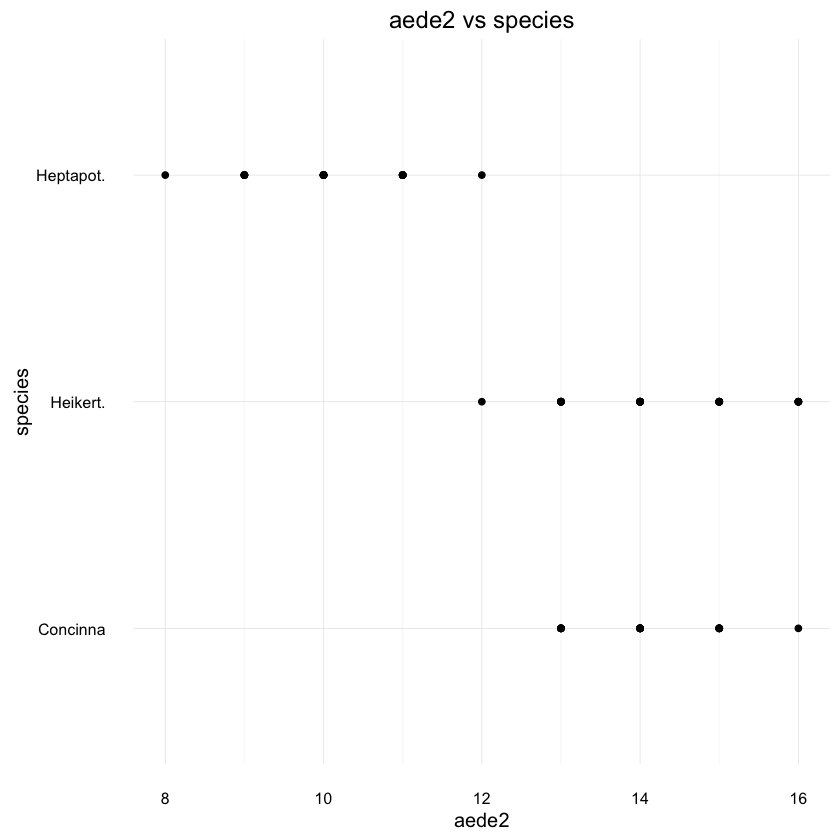

In [106]:
ggplot(df, aes(x = aede2, y = species)) + geom_point() + 
    ggtitle("aede2 vs species")

It looks like there is pretty good separation between Heptapot and the other 2 species based on `aede2` alone.

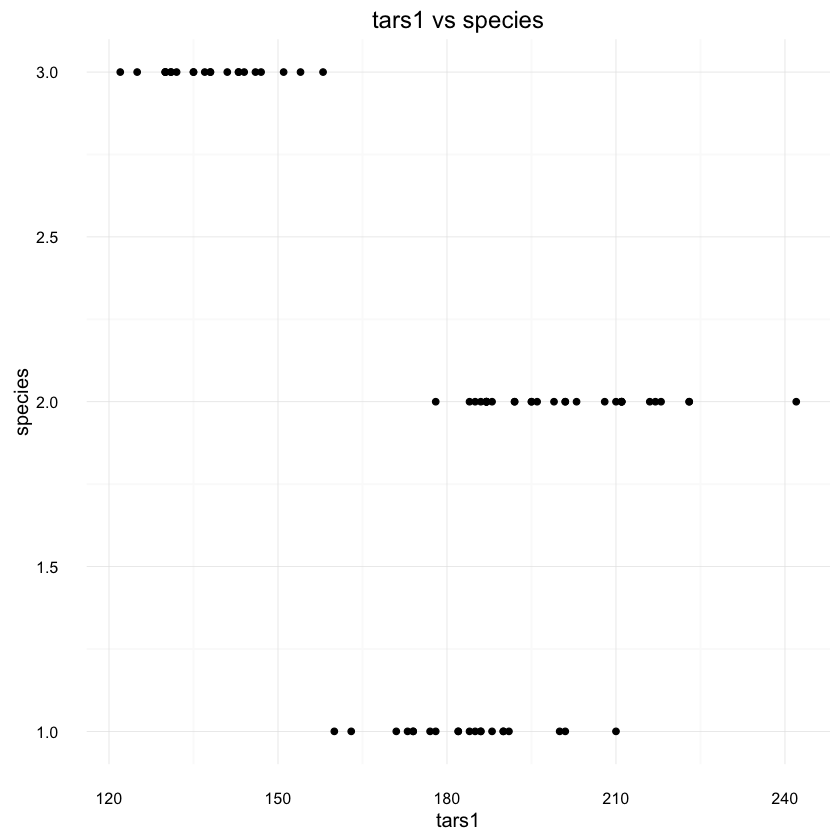

In [104]:
ggplot(df, aes(x = tars1, y = species)) + geom_point()  + 
    ggtitle("tars1 vs species")

`tars1` shows paints pretty similar picture. How about the species distribution in general?

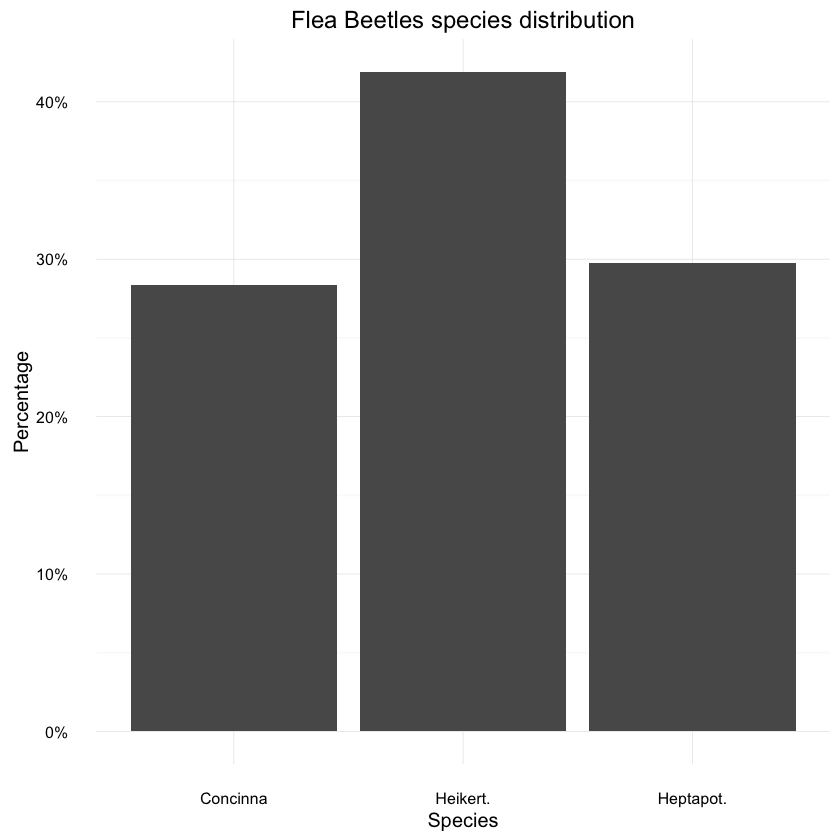

In [94]:
data <- as.data.frame(prop.table(table(df$species)))
colnames(data) <- c("Species", "Percentage")
data$Species <- species

ggplot(data=data, aes(x=Species, y=Percentage)) +
  geom_bar(position="dodge", stat="identity") + 
  ggtitle("Flea Beetles species distribution") +
  scale_y_continuous(labels=percent_format())

Looks ok, with lead to Heikert. Let's not forget that our dataset is pretty small though.

# Preprocessing

Now, let's shuffle and split our data into training and testing datasets. We'll convert the species into ints as well.

In [37]:
species <- levels(df$species)
df$species <- as.numeric(df$species)
df <- df[sample(nrow(df)),]

train_idx = createDataPartition(df$species, p=.8, list=FALSE)

In [25]:
train <- df[train_idx, ]
test <- df[-train_idx, ]

y_test <- df[-train_idx, ]$species

# Building our model

Now, let's get serious and put JAGS to a test. Here is a diagram of our model:

![](https://i.imgur.com/7beACOf.png)

You should try to understand that bottom to top. $y_i$ is what we are trying to ultimately predict. It is a categorical distribution. Then you move to the next level (up) where the softmax is defined and finally our normally distributed vague prior distributions.

Now for our model definition. It is defined in JAGS. So it is a string in R. First, we will standardize our input X for both training and testing data. Then, our $y_i$ is defined as categorical distribution (using `dcat`) that depends on our data and vague normally distributed priors.

We compute $y$ for our training and testing data withing our JAGS model.

In [109]:
modelString = "
  # Standardize the data:
  data {
    for ( j in 1:Nx ) {
      xm[j]  <- mean(x[,j])
      xsd[j] <-   sd(x[,j])
      for ( i in 1:Ntotal ) {
        zx[i,j] <- ( x[i,j] - xm[j] ) / xsd[j]
      }
      # standardize the probe values:
      for ( i in 1:Nprobe ) {
        zxProbe[i,j] <- ( xProbe[i,j] - xm[j] ) / xsd[j]
      }
    }
  }
  # Specify the model for standardized data:
  model {
    
    # Predicted y values at xProbe:
    for ( i in 1:Nprobe ) {
      yP[i] ~ dcat( zyP[1:Nout,i] ) # dcat normalizes its argument vector
      for ( r in 1:Nout ) {
        zyP[r,i] <- exp( zbeta0[r] + sum( zbeta[r,1:Nx] * zxProbe[i,1:Nx] ) ) 
      }
    }

    for ( i in 1:Ntotal ) {
      y[i] ~ dcat( explambda[1:Nout,i] ) # dcat normalizes its argument vector
      for ( r in 1:Nout ) {
        explambda[r,i] <- exp( zbeta0[r] + sum( zbeta[r,1:Nx] * zx[i,1:Nx] ) ) 
      }
    }
    # Priors vague on standardized scale:
    zbeta0[1] <- 0
    for ( j in 1:Nx ) { zbeta[1,j] <- 0 }
    for ( r in 2:Nout ) { # notice starts at 2
      zbeta0[r] ~ dnorm( 0 , 1/20^2 )  
      for ( j in 1:Nx ) {
        zbeta[r,j] ~ dnorm( 0 , 1/20^2 )
      }
    }
    # Transform to original scale:
    for ( r in 1:Nout ) {
      beta[r,1:Nx] <- zbeta[r,1:Nx] / xsd[1:Nx] 
      beta0[r] <- zbeta0[r] - sum( zbeta[r,1:Nx] * xm[1:Nx] / xsd[1:Nx] )
    }
  }
"

In [52]:
genMCMC = function( data , xName , yName , xProbe=NULL ,
                    numSavedSteps=10000 , thinSteps=1 ,
                    runjagsMethod=runjagsMethodDefault , 
                    nChains=nChainsDefault ) { 
  y = data[,yName]
  x = as.matrix(data[,xName],ncol=length(xName))
  
  Nx <- dim(x)[2]
  
  # Specify the data in a list, for later shipment to JAGS:
  dataList = list(
    x = x ,
    y = as.numeric(y) ,
    xProbe = xProbe ,
    Nprobe = nrow(xProbe) ,
    Nx = Nx ,
    Ntotal = dim(x)[1] ,
    Nout = length( unique( y ) ) # should be same as max(y)
  )
  #-----------------------------------------------------------------------------
  # THE MODEL.
  

  writeLines( modelString , con="TEMPmodel.txt" )
  #-----------------------------------------------------------------------------
  # RUN THE CHAINS
  parameters = c( "beta0" ,  "beta" ,  
                  "zbeta0" , "zbeta",
                  "xProbe" , "yP")
  adaptSteps = 500  # Number of steps to "tune" the samplers
  burnInSteps = 1000
  runJagsOut <- run.jags( method=runjagsMethod ,
                            model="TEMPmodel.txt" , 
                          monitor=parameters , 
                          data=dataList ,  
                          #inits=initsList , 
                          n.chains=nChains ,
                          adapt=adaptSteps ,
                          burnin=burnInSteps , 
                          silent.jags = TRUE,
                          sample=ceiling(numSavedSteps/nChains) ,
                          thin=thinSteps ,
                          summarise=FALSE ,
                          plots=FALSE)
  codaSamples = as.mcmc.list( runJagsOut )
  return( codaSamples )
}

In [108]:
yName <- "species"; xName <- c("tars1", "tars2", "head", "aede1", "aede2", "aede3")
 
numSavedSteps=10000 ; thinSteps=5

In [53]:
xProbe <- matrix(unlist(test[, xName]), nrow = nrow(test), byrow = TRUE)

In [54]:
library(parallel) # for detectCores().
nCores = detectCores() 
if ( !is.finite(nCores) ) { nCores = 1 } 
if ( nCores > 4 ) { 
  nChainsDefault = 4  # because JAGS has only 4 rng's.
  runjagsMethodDefault = "parallel"
}
if ( nCores == 4 ) { 
  nChainsDefault = 3  # save 1 core for other processes.
  runjagsMethodDefault = "parallel"
}
if ( nCores < 4 ) { 
  nChainsDefault = 3 
  runjagsMethodDefault = "rjags" # NOT parallel
}

In [55]:
mcmcCoda = genMCMC( data=train , xName=xName , yName=yName , xProbe = xProbe,
                    numSavedSteps=numSavedSteps , thinSteps=thinSteps)

Calling 4 simulations using the parallel method...
All chains have finished
Simulation complete.  Reading coda files...
Coda files loaded successfully
Finished running the simulation


In [31]:
mcmcMat = as.matrix(mcmcCoda)
xPcols = grep( "xProbe" , colnames(mcmcMat) , value=FALSE )
yPcols = grep( "yP" , colnames(mcmcMat) , value=FALSE )

In [32]:
maxCols <- c()
for(i in yPcols) {
  maxCols <- c(maxCols, which.max(table(mcmcMat[, i]))[[1]])
}

accuracy <- data.frame(predicted = maxCols, actual=as.numeric(y_test))


In [33]:
accuracy

predicted,actual
1,3
1,1
1,3
1,2
2,2
2,1
2,3
1,2
1,1
2,2


In [79]:
table(accuracy)

         actual
predicted 1 2 3
        1 3 2 3
        2 2 3 1

In [34]:
table(accuracy$predicted == accuracy$actual)


FALSE  TRUE 
    8     6 

In [41]:
table(accuracy$predicted == accuracy$actual)[[2]] / nrow(accuracy)

[1] 0.4285714

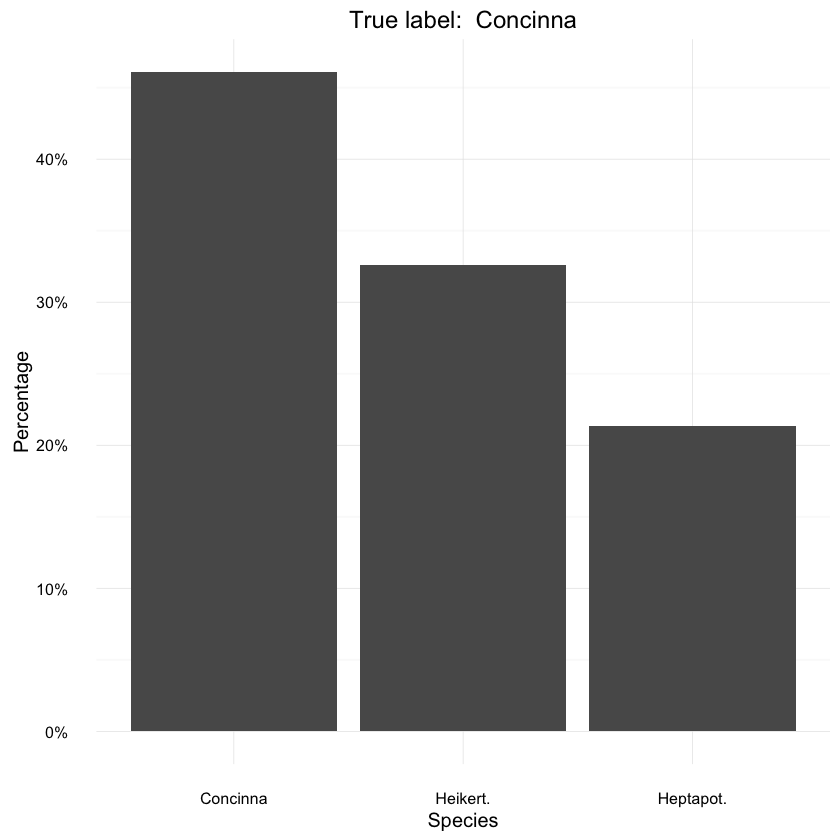

In [77]:
data <- as.data.frame(prop.table(table(mcmcMat[, ncol(mcmcMat)])))
colnames(data) <- c("Species", "Percentage")
data$Species <- species

ggplot(data=data, aes(x=Species, y=Percentage)) +
  geom_bar(position="dodge", stat="identity") + 
  ggtitle(paste("True label: ", species[y_test[length(y_test)]])) +
  scale_y_continuous(labels=percent_format())